In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib.gridspec import GridSpec

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'#'

start @ Wed Jun  8 10:27:33 2022#


In [3]:
print katcali.__version__

1.0.0


In [4]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
p_radec=np.loadtxt('radio_source2021.txt')

In [6]:
input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level3/data/'
output_file='./'

In [7]:
def cal_map_I(map_h, map_v):    
    assert(np.shape(map_h)==np.shape(map_v))
    map=(map_h+map_v)/2.   
    print 'min value h,v:',
    print np.ma.min(map_h),np.ma.min(map_v)
    assert(np.ma.min(map_h)>0)
    assert(np.ma.min(map_v)>0)
    diff_ratio=np.ma.exp(abs(np.ma.log(map_h)-np.ma.log(map_v))) #difference betwwen map h,v; 
                                                        #function to make sure maps are exchangable
    return map, diff_ratio


In [8]:
fname='1632077222'#
ant='m000'

print fname,ant

1632077222 m000


In [9]:
dh=pickle.load(open(input_file+fname+'_'+ant+'h_level3_data'))
dv=pickle.load(open(input_file+fname+'_'+ant+'v_level3_data'))

In [10]:
assert((dh['ra']==dv['ra']).all()==True)
assert((dh['dec']==dv['dec']).all()==True)
assert((dh['timestamps']==dv['timestamps']).all()==True)
assert((dh['Tgal_map']==dv['Tgal_map']).all()==True)
ra=dh['ra']
dec=dh['dec']
timestamps=dh['timestamps']
Tgal_map=dh['Tgal_map']

gain_map_h=dh['gain_map']
T_map_h=dh['T_map']
Tresi_map_h=dh['Tresi_map']
Tsm_map_h=dh['Tsm_map']
nd_s0_h=dh['nd_s0'] 
Tel_map_h=dh['Tel_map']
Tsky_map_h=T_map_h-Tel_map_h-Tsm_map_h

gain_map_v=dv['gain_map']
T_map_v=dv['T_map']
Tresi_map_v=dv['Tresi_map']
Tsm_map_v=dv['Tsm_map']
nd_s0_v=dv['nd_s0'] 
Tel_map_v=dv['Tel_map']
Tsky_map_v=T_map_v-Tel_map_v-Tsm_map_v


In [11]:
d_checker={}
d_checker['Tsm_map_h']=Tsm_map_h
d_checker['Tsm_map_v']=Tsm_map_v
d_checker['Tgal_map']=Tgal_map
d_checker['Tcmb']=Tcmb



In [12]:
freqs=kio.cal_freqs(range(4096))

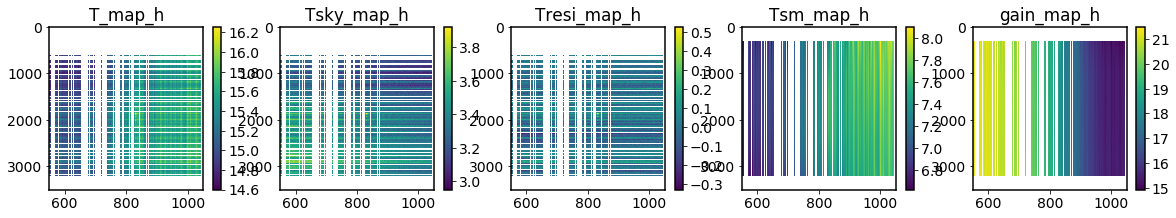

In [13]:
ch_e=1051
l=[T_map_h,Tsky_map_h,Tresi_map_h,Tsm_map_h,gain_map_h]
l_str=['T_map_h','Tsky_map_h','Tresi_map_h','Tsm_map_h','gain_map_h']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

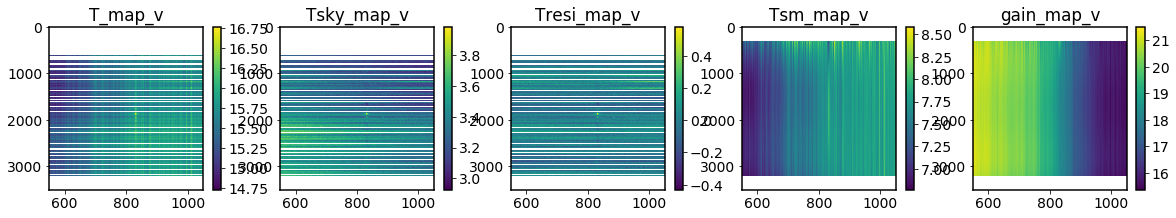

In [14]:
l=[T_map_v,Tsky_map_v,Tresi_map_v,Tsm_map_v,gain_map_v]
l_str=['T_map_v','Tsky_map_v','Tresi_map_v','Tsm_map_v','gain_map_v']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

In [15]:
assert((T_map_h.mask==Tresi_map_h.mask).all()==True)
assert((T_map_v.mask==Tresi_map_v.mask).all()==True)
div=T_map_h/T_map_v
mask_clean=div.mask.copy()
mask_clean_backup=mask_clean.copy()

In [16]:
l=[T_map_h,T_map_v,Tresi_map_h,Tresi_map_v,Tsm_map_h,Tsm_map_v,gain_map_h,gain_map_v]
l_copy=[T_map_h.copy(),T_map_v.copy(),Tresi_map_h.copy(),Tresi_map_v.copy(),Tsm_map_h.copy(),Tsm_map_v.copy(),gain_map_h.copy(),gain_map_v.copy()]

l_str=[r'$T_{cal}(\nu)$'+', pol=HH',r'$T_{cal}(\nu)$'+', pol=VV',r'$T_{res}(\nu)$'+', pol=HH',r'$T_{res}(\nu)$'+', pol=VV',
       r'$T_{rec}(\nu)$'+', pol=HH',r'$T_{rec}(\nu)$'+', pol=VV','gain'+r'$(\nu)$'+', pol=HH','gain'+r'$(\nu)$'+', pol=VV']

In [17]:
del_point0,del_point1,del_point2,del_point3,del_point4,del_point5,del_point6,del_point7=[],[],[],[],[],[],[],[]


> The iteration 1 is in progress...
masks before and after filter are same: False
3 channels masked by 5 times
> The iteration 2 is in progress...
masks before and after filter are same: False
1 channels masked by 1 times
> The iteration 3 is in progress...
masks before and after filter are same: True
0 channels masked by 0 times
***filter done after iter time 3


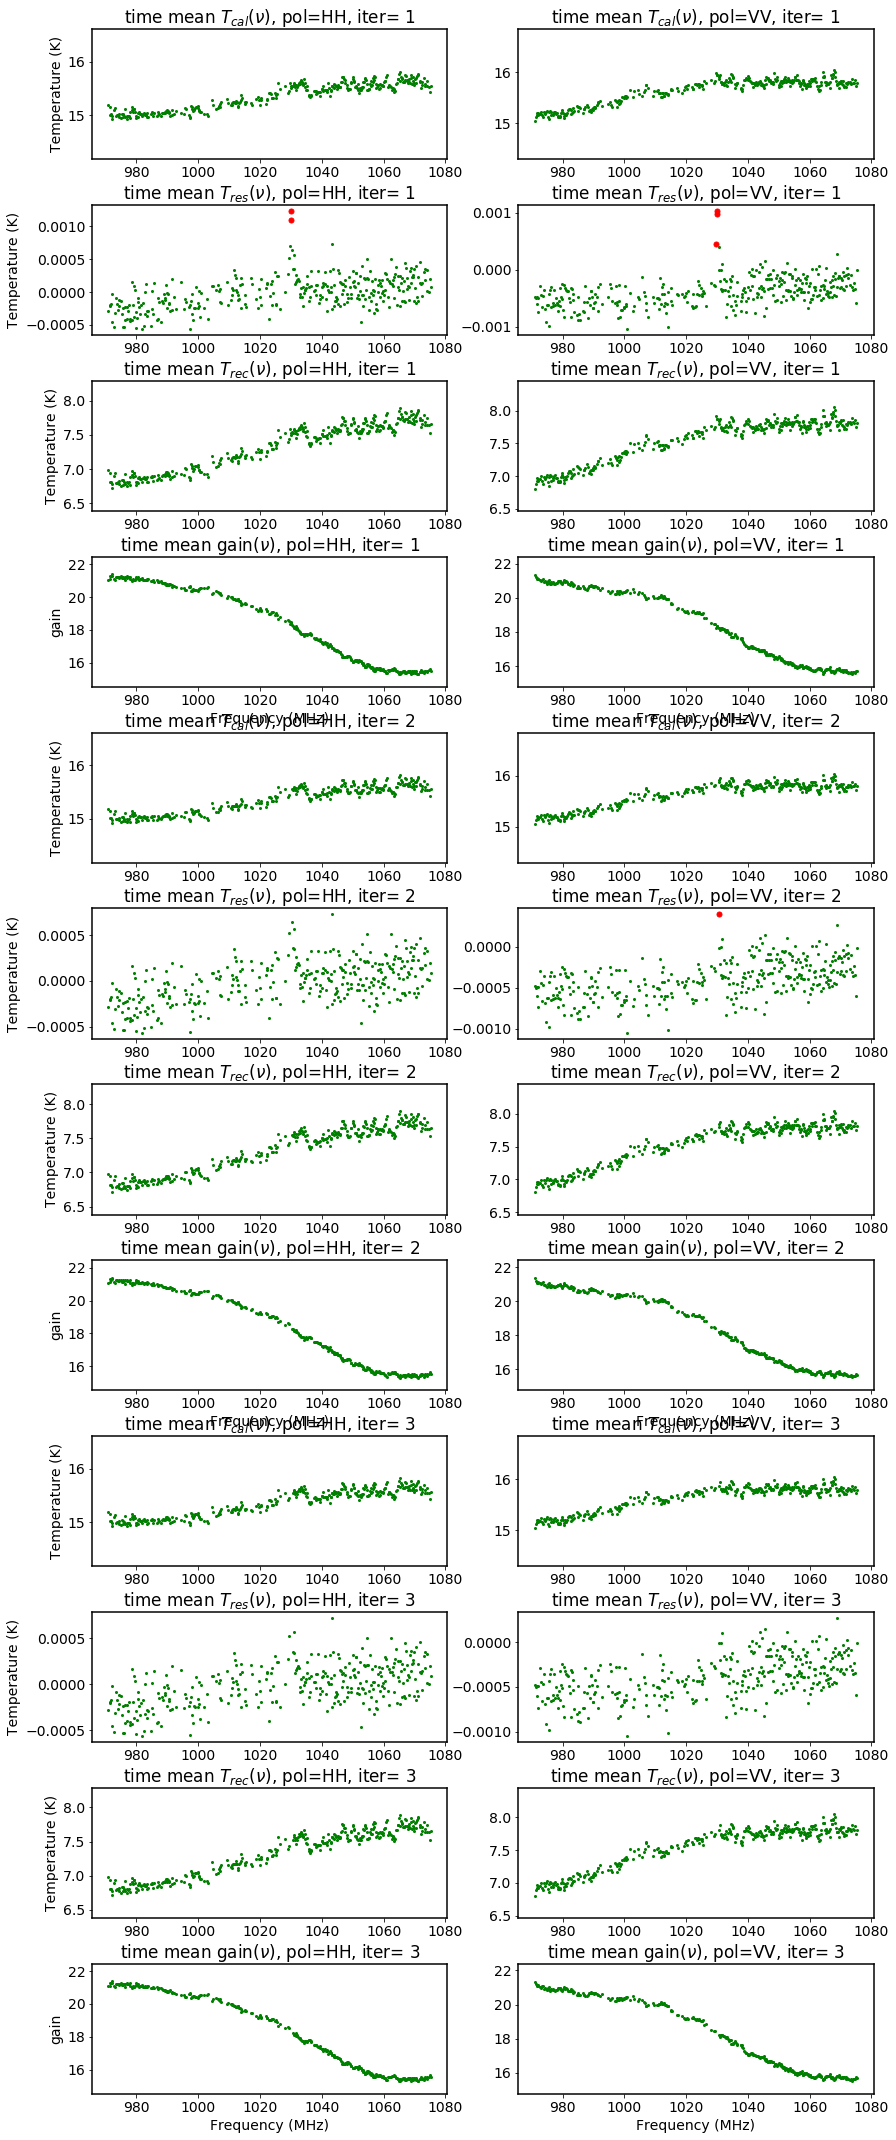

In [18]:
#####filter######
niter=6

plt.figure(figsize=(14,len(l)*niter*1.6))
plt.subplots_adjust (wspace=0.2, hspace=0.35) 
for i in range(niter):
    print '> The iteration '+str(i+1)+' is in progress...'
    mask_clean2=mask_clean.copy()
    
    del_point=[]
    
    for l_i in range(len(l)):
        a=l[l_i]
        plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
        a_ch=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0)
        plt.plot(freqs/1e6,a_ch,'g.', ms=4)
        if l_i !=2 and l_i!=3:
            plt.ylim(a_ch.min()*0.95,a_ch.max()*1.05)
        
        ax1=kf.curve_filter_ma_array(range(550,1051),a_ch[550:1051],sigma=4.)#550-1050 filter
        plt.plot(freqs[ax1]/1e6,a_ch[ax1],'.',color='r',ms=10) #deleted data
        mask_clean2[:,ax1]=True ###apply to the mask
        del_point+=list(ax1)
        '''
        ax2=kf.curve_filter_ma_array(range(2150,3101),a_ch[2150:3101],sigma=4.)#2150-3100 filter
        plt.plot(freqs[ax2]/1e6,a_ch[ax2],'.',color='r',ms=10) #deleted data
        mask_clean2[:,ax2]=True ###apply to the mask
        del_point+=list(ax2)
        
        ax3=kf.curve_filter_ma_array(range(550,3101),a_ch[550:3101],sigma=4.,k=1)
        plt.plot(freqs[ax3]/1e6,a_ch[ax3],'.',color='r',ms=10) #deleted data
        mask_clean2[:,ax3]=True ###apply to the mask
        del_point+=list(ax3)
        '''
        if l_i==0:
            del_point0+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==1:
            del_point1+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==2:
            del_point2+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==3:
            del_point3+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==4:
            del_point4+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==5:
            del_point5+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==6:
            del_point6+=list(ax1)#+list(ax2)+list(ax3)
        if l_i==7:
            del_point7+=list(ax1)#+list(ax2)+list(ax3)
    
        
        plt.title('time mean '+ l_str[l_i]+', iter= '+str(i+1))
        
        if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
            plt.ylabel('Temperature (K)')
            
        if (l_i+1) % 7 ==0:
            plt.ylabel('gain')    
            
            
        if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
            plt.xlabel('Frequency (MHz)')
            
    print 'masks before and after filter are same:',
    print (mask_clean==mask_clean2).all()
    mask_clean=mask_clean2.copy()
    
    print str(len(set(del_point))) + ' channels masked by '+str(len(del_point))+' times'
    if len(del_point)==0:
        print '***filter done after iter time '+str(i+1) 
        break
plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_iter'+str(i+1)+'.pdf', bbox_inches='tight')
plt.show()

In [19]:
print del_point0
print del_point1
print del_point2
print del_point3
print del_point4
print del_point5
print del_point6
print del_point7

[]
[]
[832, 833]
[831, 832, 833, 835]
[]
[]
[]
[]


In [20]:
del_point_all=del_point0+del_point1+del_point2+del_point3+del_point4+del_point5+del_point6+del_point7
del_point_all=list(set(del_point_all))
print len(del_point_all)

4


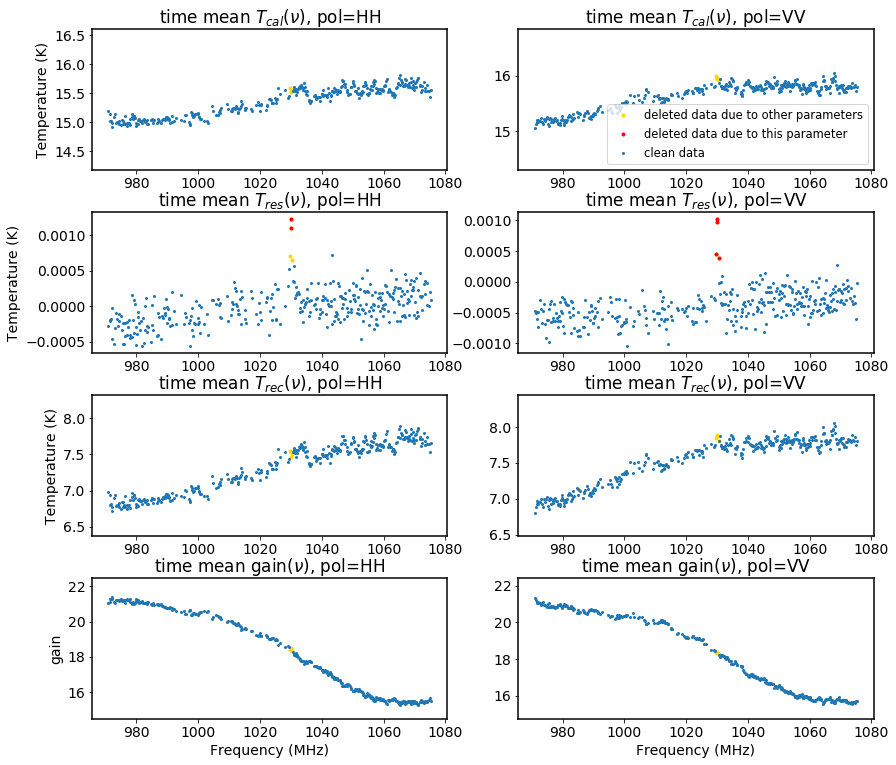

In [21]:
plt.figure(figsize=(14,80))
plt.subplots_adjust (wspace=0.2, hspace=0.3) 

for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
    
    
    if l_i==0:
        del_point_plot=del_point0
    if l_i==1:
        del_point_plot=del_point1
    if l_i==2:
        del_point_plot=del_point2
    if l_i==3:
        del_point_plot=del_point3
    if l_i==4:
        del_point_plot=del_point4
    if l_i==5:
        del_point_plot=del_point5
    if l_i==6:
        del_point_plot=del_point6
    if l_i==7:
        del_point_plot=del_point7
        
    a_ch=np.ma.mean(a,axis=0) #raw
    plt.plot(freqs[del_point_all]/1e6,a_ch[del_point_all],'.',color='gold',ms=6) #all deleted data
    plt.plot(freqs[del_point_plot]/1e6,a_ch[del_point_plot],'.',color='r',ms=6) #deleted data
    
    a_ch1=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0) #clean 
    plt.plot(freqs/1e6,a_ch1,'.', ms=4) #clean data
    
    if l_i !=2 and l_i!=3:
        plt.ylim(a_ch.min()*0.95,a_ch.max()*1.05)
 
    plt.title('time mean '+ l_str[l_i])

    if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
        plt.ylabel('Temperature (K)')

    if (l_i+1) % 7 ==0:
        plt.ylabel('gain')    

    if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
        plt.xlabel('Frequency (MHz)')
        
    if l_i==1:
        plt.legend(['deleted data due to other parameters', 'deleted data due to this parameter','clean data'], fontsize=11.5)
plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_final.pdf', bbox_inches='tight')
plt.show()

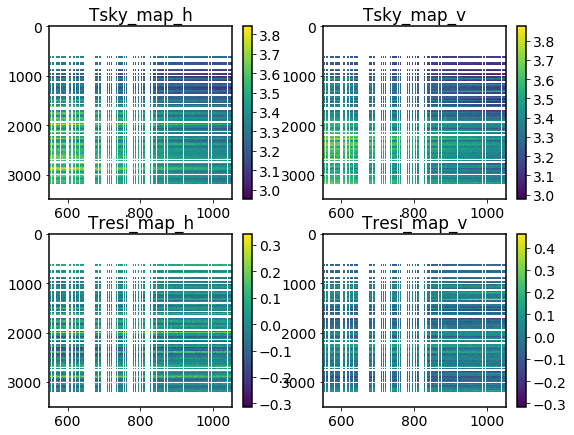

In [22]:
l=[Tsky_map_h, Tsky_map_v, Tresi_map_h, Tresi_map_v]
l_str=['Tsky_map_h', 'Tsky_map_v', 'Tresi_map_h', 'Tresi_map_v']
plt.figure(figsize=(9,7))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2,2,l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(np.ma.array(a,mask=mask_clean),aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

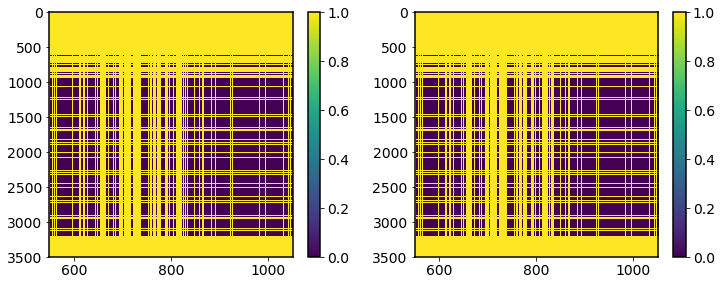

In [23]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.imshow(mask_clean_backup,aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.subplot(122)
plt.imshow(mask_clean,aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.show()

In [24]:
Tsky_map_h=np.ma.array(Tsky_map_h,mask=mask_clean)
Tsky_map_v=np.ma.array(Tsky_map_v,mask=mask_clean)

Tresi_map_h=np.ma.array(Tresi_map_h,mask=mask_clean)
Tresi_map_v=np.ma.array(Tresi_map_v,mask=mask_clean)


In [25]:
Tsky_map,Tsky_ratio=cal_map_I(Tsky_map_h, Tsky_map_v)
Tresi_map=(Tresi_map_h+Tresi_map_v)/2.
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

min value h,v: 2.95056407977 2.97654637961


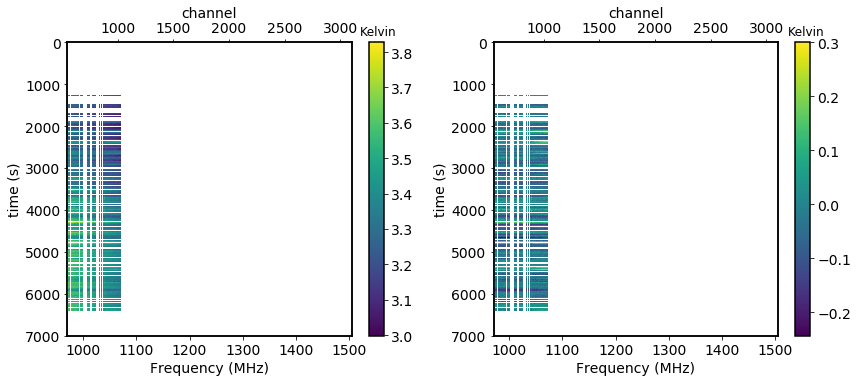

In [26]:
plt.figure(figsize=(14,5.4))
#plt.subplots_adjust (wspace=0.2, hspace=0) 
plt.subplot(121)
plt.imshow(Tsky_map[:,550:3101],aspect='auto',extent=(freqs[550]/1e6,freqs[3101]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$I_{sky}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tsky_map[:,550:3101], aspect='auto',extent=(550,3101,len(timestamps)*2,0))
plt.xlabel('channel')
plt.subplot(122)
plt.imshow(Tresi_map[:,550:3101],aspect='auto',vmax=0.3, extent=(freqs[550]/1e6,freqs[3101]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$I_{resi}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-45, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tresi_map[:,550:3101], aspect='auto',vmax=0.3, extent=(550,3101,len(timestamps)*2,0))
plt.xlabel('channel')
plt.savefig(output_file+'F_'+fname+'_'+ant+'_Inten.pdf', bbox_inches='tight')
plt.show()

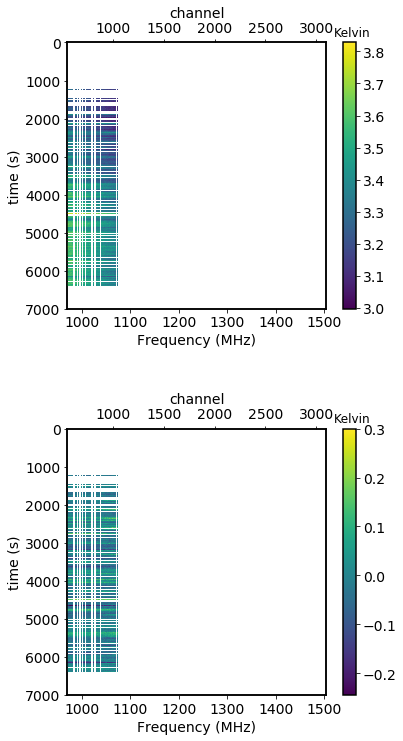

In [27]:
plt.figure(figsize=(5.8,12))
plt.subplots_adjust(wspace=0,hspace=.45)
plt.subplot(211)
plt.imshow(Tsky_map[:,550:3101],aspect='auto',extent=(freqs[550]/1e6,freqs[3101]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$T_{sky}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-33, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tsky_map[:,550:3101], aspect='auto',extent=(550,3101,len(timestamps)*2,0))
plt.xlabel('channel')
plt.subplot(212)
plt.imshow(Tresi_map[:,550:3101],aspect='auto',vmax=0.3, extent=(freqs[550]/1e6,freqs[3101]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$T_{res}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-45, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tresi_map[:,550:3101], aspect='auto',vmax=0.3, extent=(550,3101,len(timestamps)*2,0))
plt.xlabel('channel')
plt.savefig(output_file+'F_'+fname+'_'+ant+'_Inten.pdf', bbox_inches='tight')
plt.show()

In [28]:
assert((Tsky_ratio.mask==mask_clean).all()==True)
print np.ma.max(Tsky_ratio)

1.15950335316


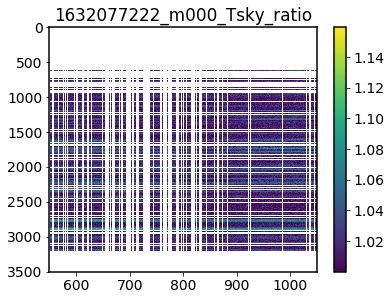

In [29]:
plt.figure(figsize=(6,4.5))
plt.imshow(Tsky_ratio,aspect='auto')
plt.xlim(550,ch_e)
plt.title(fname+'_'+ant+'_Tsky_ratio')
plt.colorbar()
plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio.png')
plt.show()

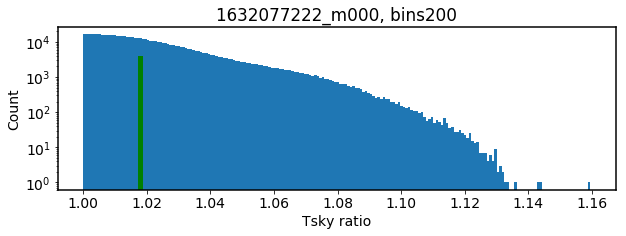

In [30]:
bins=200

plt.figure(figsize=(10,3))
max=np.sum(Tsky_ratio.mask==False)/bins
median=np.ma.median(Tsky_ratio)
plt.hist(Tsky_ratio[~Tsky_ratio.mask],bins=bins,log=True)
plt.plot([median,median],[0,max],'g-',lw=5)
plt.xlabel('Tsky ratio')
plt.ylabel('Count')
plt.title(fname+'_'+ant+', bins'+str(bins))
plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio_his.png')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


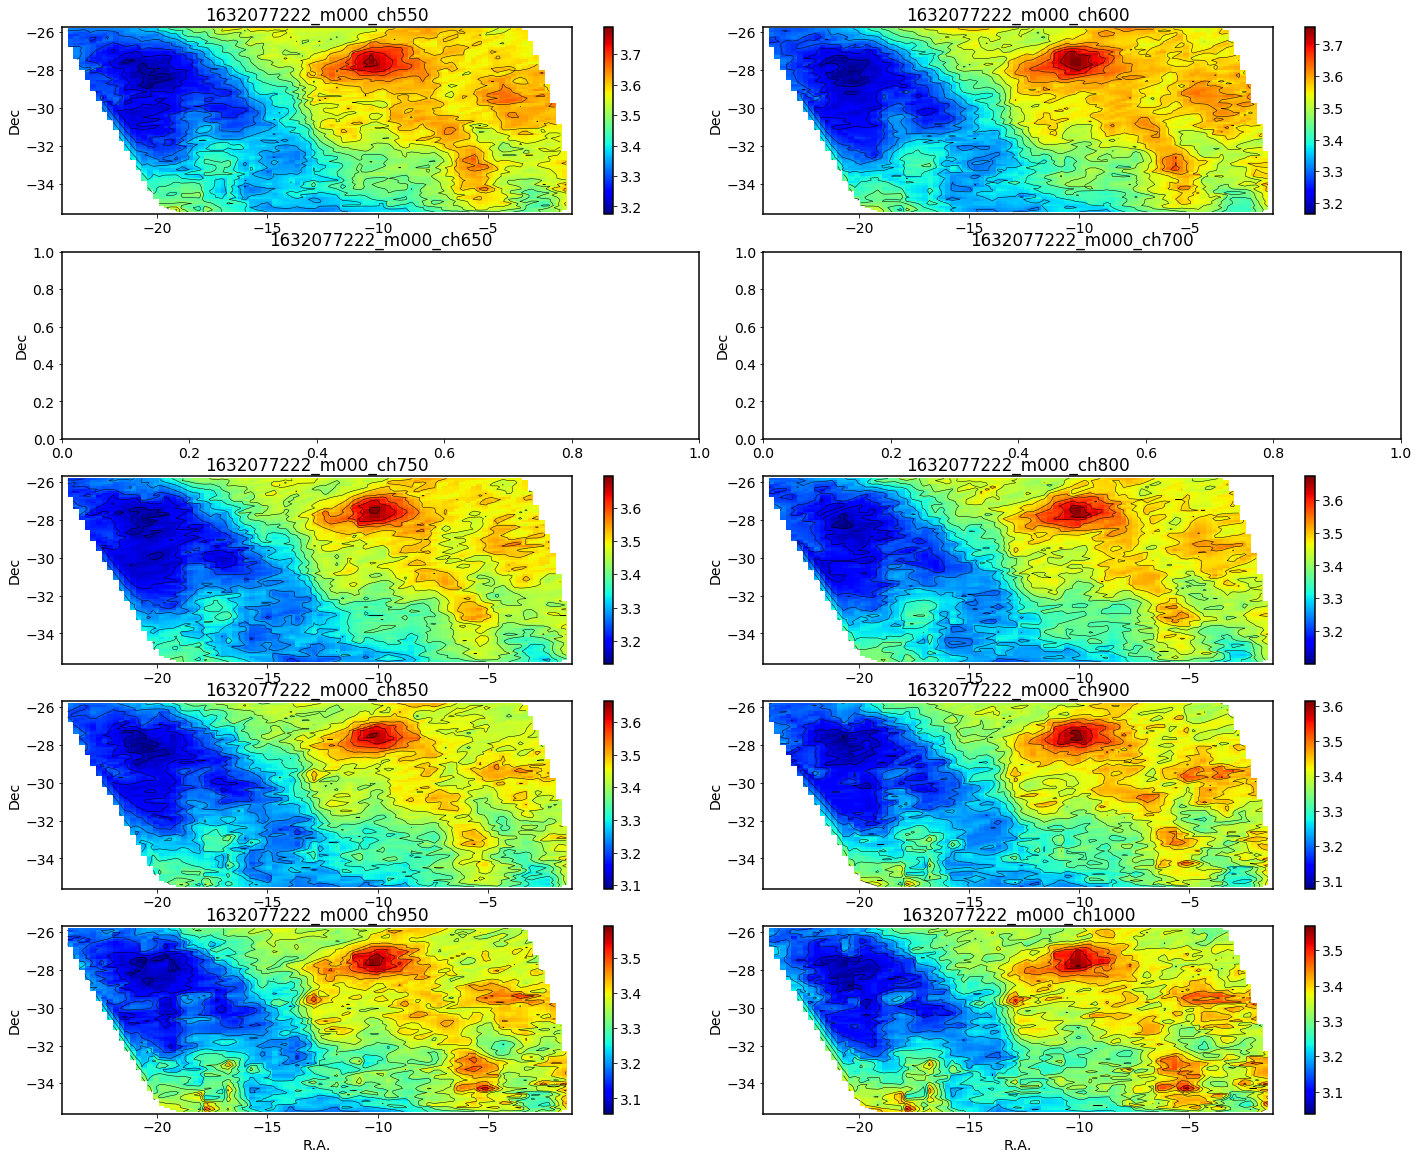

In [31]:
ch_plot_list=[550,600,650,700,750,800,850,900,950,1000]#[600,700,800,900,1000,2200,2400,2600,2800,3000]
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.1, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tsky_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    if (p_data.mask==True).all()==False:
        kv.plot_data(ra,dec, p_data,gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
plt.savefig(output_file+fname+'_'+ant+'_Tsky_map.png')
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


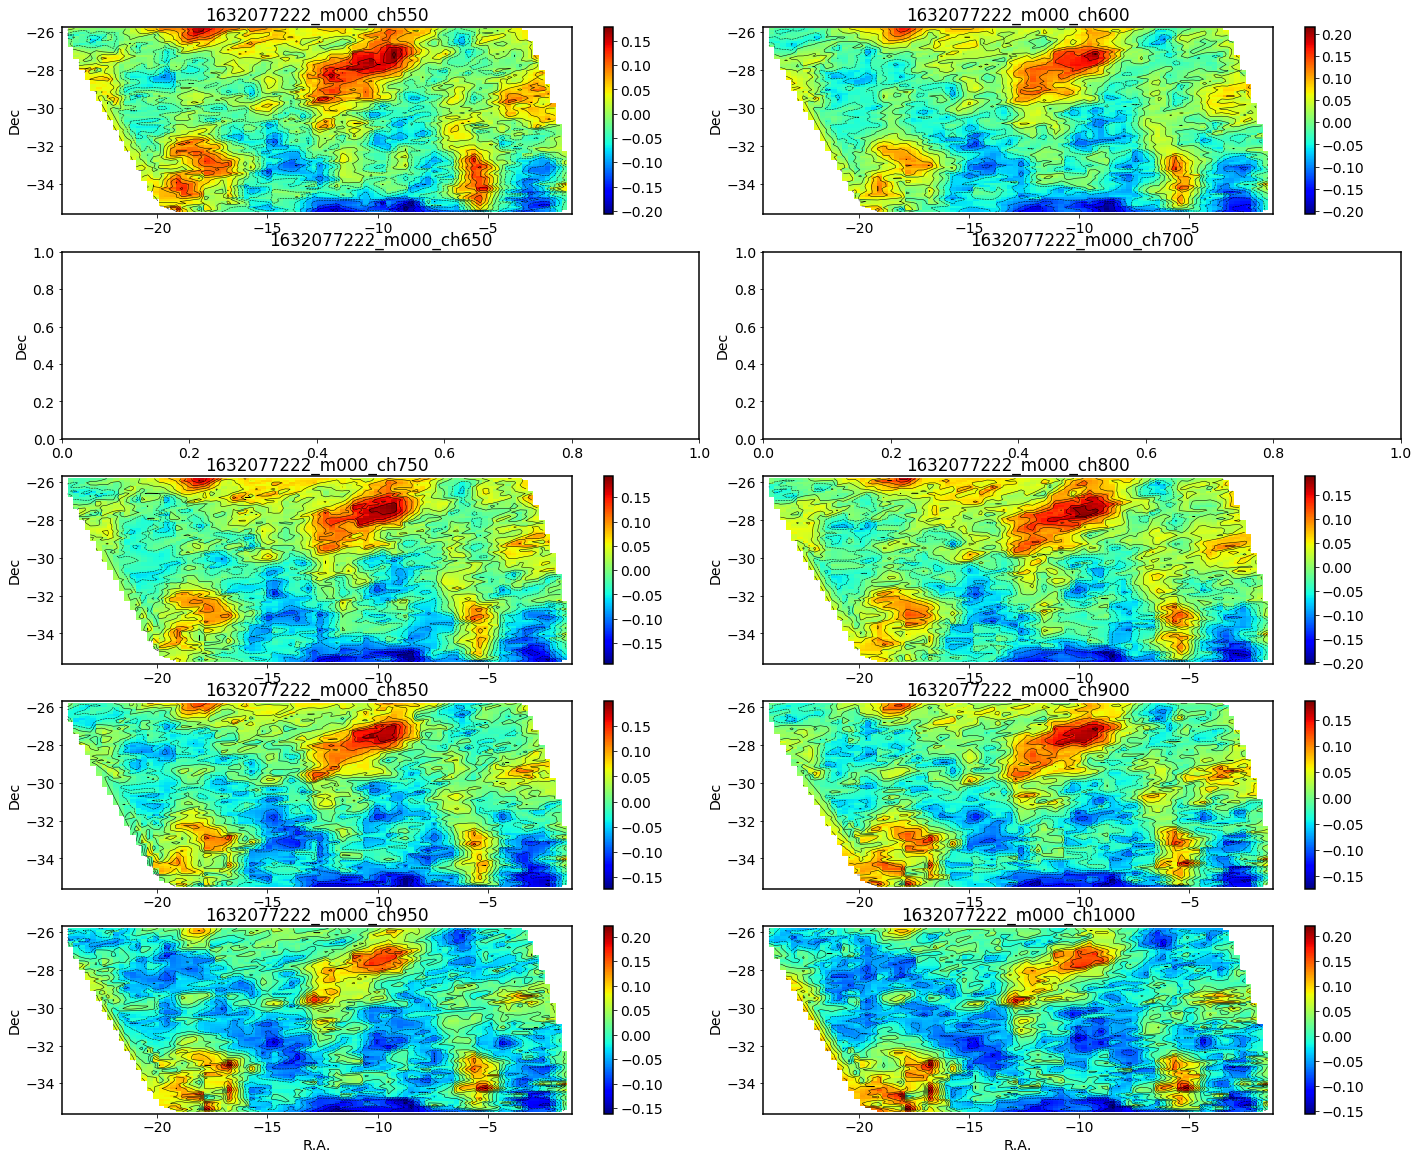

In [32]:
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.1, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tresi_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    if (p_data.mask==True).all()==False:
        kv.plot_data(ra,dec, p_data,gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
plt.savefig(output_file+fname+'_'+ant+'_Tresi_map.png')
plt.show()


In [33]:
assert((Tsky_map.mask==mask_clean).all()==True)
assert((Tresi_map.mask==mask_clean).all()==True)
assert((Tsky_ratio.mask==mask_clean).all()==True)

d={}
d['Tsky_map']=Tsky_map
d['Tresi_map']=Tresi_map
d['Tsky_ratio']=Tsky_ratio

d['timestamps']=timestamps
d['ra']=ra
d['dec']=dec
assert((nd_s0_h==nd_s0_v).all())
d['nd_s0']=nd_s0_h
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_data','wb')
pickle.dump(d,fs,protocol=2)
fs.close()

d1={}

d1['Inten_mask']=mask_clean
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_mask','wb')
pickle.dump(d1,fs,protocol=2)
fs.close()

In [34]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jun  8 10:28:41 2022#


In [35]:
#end

# reload data to check

In [36]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Wed Jun  8 10:28:41 2022...


In [37]:
d2=pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/data/'+fname+'_'+ant+'_level4_data'))
assert((d2['Tsky_map'].mask==d2['Tresi_map'].mask).all()==True)

In [38]:
print d2.keys()

['Tresi_map', 'nd_s0', 'Tsky_map', 'ra', 'timestamps', 'Tsky_ratio', 'dec']


In [39]:
print d2['Tsky_ratio']

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


In [40]:
assert((d2['Tsky_map'].data==Tsky_map.data).all()==True)
assert((d2['Tsky_map'].mask==Tsky_map.mask).all()==True)

assert((d2['Tresi_map'].data==Tresi_map.data).all()==True)
assert((d2['Tresi_map'].mask==Tresi_map.mask).all()==True)

print '# all same!'

# all same!


In [41]:
print d2['timestamps']

[  1.63207724e+09   1.63207724e+09   1.63207724e+09 ...,   1.63208423e+09
   1.63208423e+09   1.63208424e+09]


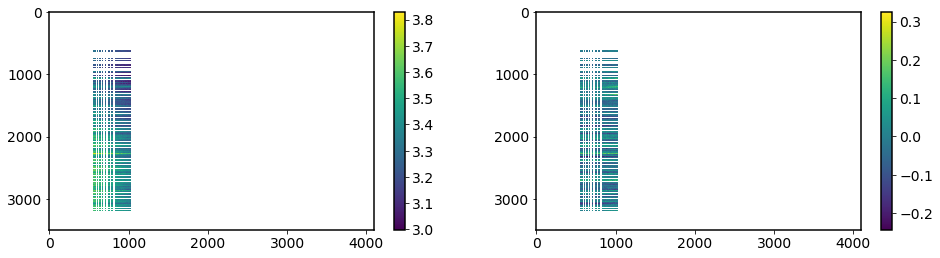

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(d2['Tsky_map'],aspect='auto')
plt.colorbar()
plt.subplot(122)
plt.imshow(d2['Tresi_map'],aspect='auto')
plt.colorbar()
plt.show()

In [43]:
d3=pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/mask/'+fname+'_'+ant+'_level4_mask'))

In [44]:
print d3.keys()

['Inten_mask']


In [45]:
assert((d3['Inten_mask']==mask_clean).all()==True)

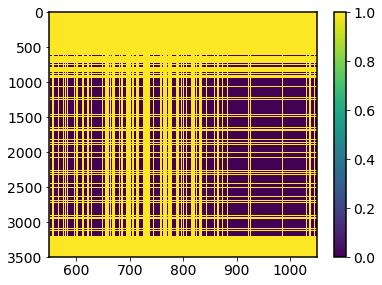

In [46]:
plt.figure(figsize=(6,4.5))
plt.imshow(d3['Inten_mask'],aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.show()

In [47]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jun  8 10:28:45 2022#
